<a href="https://colab.research.google.com/github/R-Madhuram/UC-BerkeleyCapstone_CreditCardFraudDetection/blob/main/notebooks/3_ensemble_methods/7_Ensemble_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HistGradient Boosting
---



---






## Importing the Libraries

In [ ]:
# Import the libraries
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier


In [ ]:
!pip install catboost 
from catboost import CatBoostClassifier


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.5 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc,RocCurveDisplay,PrecisionRecallDisplay

In [ ]:
import pandas as pd
import numpy as np
import pickle

In [ ]:
from sklearn import preprocessing
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.model_selection import cross_validate

## Importing helper functions



In [ ]:
# Import the helper functions
# Import the required functions from the helper function file
from helper_functions_ml import createMetricsDF,computeModelMetrics,computeAndPlotMetrics

## Import the Data (training and testing)

In [ ]:
# Read the training data
df_train = pd.read_csv('df.csv')
print(df_train.head())

df_train = df_train.drop('Unnamed: 0', axis=1)
df_train.head(3)
print(df_train.shape)

   Unnamed: 0  TransactionID  isFraud  TransactionDT  TransactionAmt  \
0           0        2987000        0          86400        1.835691   
1           1        2987001        0          86401        1.462398   
2           2        2987002        0          86469        1.770852   
3           3        2987003        0          86499        1.698970   
4           4        2987004        0          86506        1.698970   

   ProductCD  card1  card2  card3  card4  ...  id_36  id_37  id_38  \
0          4  13926   -1.0  150.0      1  ...      2      2      2   
1          4   2755  404.0  150.0      2  ...      2      2      2   
2          4   4663  490.0  150.0      4  ...      2      2      2   
3          4  18132  567.0  150.0      2  ...      2      2      2   
4          1   4497  514.0  150.0      2  ...      0      1      1   

   DeviceType  DeviceInfo  P_emaildomain_addr1_card1  card1_card2  \
0           1        1735                      63363         3655   
1       

In [ ]:
# CP cannot be used to copy file here because numFolds is a variable and hence the filenames will change based on the number of folds.
# instead of using linux CP command we use SHUTIL copy 

# read the K fold train and dev indices

numFolds = 3

import shutil # file copy package. 

srcFileName = 'Classification_Products\train_dev_indices_' + str(numFolds) + '.pickle' 
train_dev_indices_file = 'train_dev_indices_' + str(numFolds) + '.pickle'
# !cp  srcFileName destFileName
shutil.copyfile(srcFileName, train_dev_indices_file)


'train_dev_indices_3.pickle'

In [ ]:
# read the train dev indices file
# train_dev_indices_df = pd.read_csv(train_dev_indices_file)
# train_dev_indices_df.head()

with open(train_dev_indices_file, 'rb') as handle:
    train_dev_indices = pickle.load(handle)
train_dev_indices

{'train': [array([195756, 195757, 195758, ..., 590537, 590538, 590539]),
  array([     0,      1,      2, ..., 590537, 590538, 590539]),
  array([     0,      1,      2, ..., 397410, 397417, 397418])],
 'dev': [array([     0,      1,      2, ..., 221151, 221172, 221182]),
  array([195756, 195757, 195758, ..., 397410, 397417, 397418]),
  array([393481, 393482, 393483, ..., 590537, 590538, 590539])]}

In [ ]:
# Getting dataready
X = df_train.drop(columns = ['isFraud','TransactionID'])
y = df_train['isFraud']

In [ ]:
# List of categorical and numerical columns in merged dataset

## Numerical columns

num_column_lst_final = []
for icol in X.columns:
  if X[icol].dtypes in ['float64', 'int64']:
    num_column_lst_final.append(icol)
print(f"The columns that have numerical features are: '{num_column_lst_final}'")
print(f"The number of columns that have numerical features are: '{len(num_column_lst_final)}'")

print('\n')

## Categorical Columns
cat_column_lst_final = []
for icol in X.columns:
  if X[icol].dtypes in ['object']:
    cat_column_lst_final.append(icol)
print(f"The columns that have categorical features are: '{cat_column_lst_final}'")
print(f"The number of columns that have categorical features are: '{len(cat_column_lst_final)}'")


The columns that have numerical features are: '['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C3', 'C5', 'D1', 'D3', 'D4', 'D8', 'D9', 'D10', 'D13', 'D14', 'M1', 'M2', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V4', 'V6', 'V10', 'V12', 'V14', 'V15', 'V19', 'V23', 'V25', 'V27', 'V35', 'V37', 'V39', 'V44', 'V46', 'V53', 'V55', 'V61', 'V66', 'V75', 'V77', 'V82', 'V86', 'V95', 'V98', 'V99', 'V104', 'V107', 'V108', 'V109', 'V117', 'V118', 'V120', 'V121', 'V123', 'V124', 'V129', 'V135', 'V138', 'V139', 'V141', 'V144', 'V148', 'V161', 'V169', 'V170', 'V172', 'V173', 'V174', 'V184', 'V194', 'V208', 'V209', 'V214', 'V220', 'V221', 'V223', 'V224', 'V226', 'V227', 'V228', 'V238', 'V240', 'V241', 'V250', 'V260', 'V270', 'V281', 'V282', 'V284', 'V286', 'V288', 'V290', 'V300', 'V305', 'V313', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',

## Ensemble model(s)


### BOOSTING METHODS

#### 1. Default model


In [ ]:
# Intantiate a histgradient boosting classifier with default parameters

#clf_hist = HistGradientBoostingClassifier()

In [ ]:
# loop through each fold, retrieve the train and dev ids for each fold before running the basic HistBoost Classifier model on each fold
y_pred_train = {}
y_pred_dev = {}

y_pred_train_prob = {}
y_pred_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe = Pipeline([('preprocessor', preprocessor), ('clf_hist', HistGradientBoostingClassifier())])
  pipe.fit(X_train,y_train)

  y_pred_train[i_fold] = pipe.predict(X_train)
  y_pred_dev[i_fold] = pipe.predict(X_dev)

  y_pred_train_prob[i_fold] = pipe.predict_proba(X_train)[:,1]
  y_pred_dev_prob[i_fold] = pipe.predict_proba(X_dev)[:,1]

#### 2. Model 1 (Hyperparameter tuned)

In [ ]:
# loop through each fold, retrieve the train and dev ids for each fold before running the basic logisitic regression model on each fold
y_pred_tunedHistGB_train = {}
y_pred_tunedHistGB_dev = {}

y_pred_tunedHistGB_train_prob = {}
y_pred_tunedHistGB_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe = Pipeline([('preprocessor', preprocessor), 
                   ('clf_hist', HistGradientBoostingClassifier(l2_regularization=1.0, class_weight ='balanced',
                                                              max_bins= 50, max_depth=50, validation_fraction=0.18, max_iter=300, min_samples_leaf=32))
                   ])
  pipe.fit(X_train,y_train)

  y_pred_tunedHistGB_train[i_fold] = pipe.predict(X_train)
  y_pred_tunedHistGB_dev[i_fold] = pipe.predict(X_dev)

  y_pred_tunedHistGB_train_prob[i_fold] = pipe.predict_proba(X_train)[:,1]
  y_pred_tunedHistGB_dev_prob[i_fold] = pipe.predict_proba(X_dev)[:,1]

#### 3. Model 2

In [ ]:
# loop through each fold, retrieve the train and dev ids for each fold before running the basic logisitic regression model on each fold
## model 2 
y_pred2_tunedHistGB_train = {}
y_pred2_tunedHistGB_dev = {}

y_pred2_tunedHistGB_train_prob = {}
y_pred2_tunedHistGB_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe = Pipeline([('preprocessor', preprocessor), 
                   ('clf_hist', HistGradientBoostingClassifier(l2_regularization=1.0, class_weight ='balanced',
                                                              max_bins= 10, max_depth=70, validation_fraction=0.18, max_iter=300, min_samples_leaf=32))
                   ])
  pipe.fit(X_train,y_train)

  y_pred2_tunedHistGB_train[i_fold] = pipe.predict(X_train)
  y_pred2_tunedHistGB_dev[i_fold] = pipe.predict(X_dev)

  y_pred2_tunedHistGB_train_prob[i_fold] = pipe.predict_proba(X_train)[:,1]
  y_pred2_tunedHistGB_dev_prob[i_fold] = pipe.predict_proba(X_dev)[:,1]

#### 4. Model 3

In [ ]:
# loop through each fold, retrieve the train and dev ids for each fold before running the basic logisitic regression model on each fold
## model 3 
y_pred3_tunedHistGB_train = {}
y_pred3_tunedHistGB_dev = {}

y_pred3_tunedHistGB_train_prob = {}
y_pred3_tunedHistGB_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe = Pipeline([('preprocessor', preprocessor), 
                   ('clf_hist', HistGradientBoostingClassifier(l2_regularization=1.0, class_weight ='balanced',
                                                              max_bins= 10, max_depth=150, validation_fraction=0.18, max_iter=200, 
                                                               min_samples_leaf=70, max_leaf_nodes=100))
                   ])
  pipe.fit(X_train,y_train)

  y_pred3_tunedHistGB_train[i_fold] = pipe.predict(X_train)
  y_pred3_tunedHistGB_dev[i_fold] = pipe.predict(X_dev)

  y_pred3_tunedHistGB_train_prob[i_fold] = pipe.predict_proba(X_train)[:,1]
  y_pred3_tunedHistGB_dev_prob[i_fold] = pipe.predict_proba(X_dev)[:,1]

#### 5. Model 4

In [ ]:
# loop through each fold, retrieve the train and dev ids for each fold before running the basic logisitic regression model on each fold
## model 4
y_pred4_tunedHistGB_train = {}
y_pred4_tunedHistGB_dev = {}

y_pred4_tunedHistGB_train_prob = {}
y_pred4_tunedHistGB_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe = Pipeline([('preprocessor', preprocessor), 
                   ('clf_hist', HistGradientBoostingClassifier(l2_regularization=1.0, class_weight ='balanced',
                                                              max_bins= 10, max_depth=150, validation_fraction=0.18, max_iter=300, 
                                                               min_samples_leaf=120, max_leaf_nodes=100))
                   ])
  pipe.fit(X_train,y_train)

  y_pred4_tunedHistGB_train[i_fold] = pipe.predict(X_train)
  y_pred4_tunedHistGB_dev[i_fold] = pipe.predict(X_dev)

  y_pred4_tunedHistGB_train_prob[i_fold] = pipe.predict_proba(X_train)[:,1]
  y_pred4_tunedHistGB_dev_prob[i_fold] = pipe.predict_proba(X_dev)[:,1]

#### 6. Model 5

In [ ]:
# loop through each fold, retrieve the train and dev ids for each fold before running the basic logisitic regression model on each fold
## model 5 
y_pred5_tunedHistGB_train = {}
y_pred5_tunedHistGB_dev = {}

y_pred5_tunedHistGB_train_prob = {}
y_pred5_tunedHistGB_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe = Pipeline([('preprocessor', preprocessor), 
                   ('clf_hist', HistGradientBoostingClassifier(l2_regularization=1.0, class_weight ='balanced',
                                                              max_bins= 10, max_depth=70, validation_fraction=0.18, max_iter=500, min_samples_leaf=100))
                   ])
  pipe.fit(X_train,y_train)

  y_pred5_tunedHistGB_train[i_fold] = pipe.predict(X_train)
  y_pred5_tunedHistGB_dev[i_fold] = pipe.predict(X_dev)

  y_pred5_tunedHistGB_train_prob[i_fold] = pipe.predict_proba(X_train)[:,1]
  y_pred5_tunedHistGB_dev_prob[i_fold] = pipe.predict_proba(X_dev)[:,1]

#### 7. SMOTE sampled 

In [ ]:
# Install imbalanced learn within the conda environment
!pip install --upgrade imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 KB 6.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [ ]:
# SMOTE Sampling for the imbalanced dataset
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
from sklearn.model_selection import StratifiedKFold
numFolds = 3
skf = StratifiedKFold(n_splits=numFolds)

In [ ]:
from math import sqrt

y_pred6_train = {}  
y_pred6_dev = {}

y_pred6_train_prob = {}
y_pred6_dev_prob = {}

y_train_folds_smote = {}
y_dev_folds_smote ={}

i_fold=0

for train, dev in skf.split(X_smote, y_smote):
  X_train = X_smote.loc[train,:]
  X_dev = X_smote.loc[dev,:]

  y_train = y_smote[train]
  y_dev = y_smote[dev]

  y_train_folds_smote[i_fold] = y_train
  y_dev_folds_smote[i_fold] = y_dev

  scale_pos_weight = sqrt(np.count_nonzero(y_train==0)/np.count_nonzero(y_train))

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe_smote = Pipeline([('preprocessor', preprocessor), 
                   ('clf_hist_smote', HistGradientBoostingClassifier(l2_regularization=1.0, class_weight ='balanced',
                                                              max_bins= 10, max_depth=150, validation_fraction=0.18, max_iter=300, 
                                                               min_samples_leaf=120, max_leaf_nodes=100,random_state=42))
                 ])
  pipe_smote.fit(X_train,y_train)

  y_pred6_train[i_fold] = pipe_smote.predict(X_train)
  y_pred6_dev[i_fold] = pipe_smote.predict(X_dev)

  y_pred6_train_prob[i_fold] = pipe_smote.predict_proba(X_train)[:,1]
  y_pred6_dev_prob[i_fold] = pipe_smote.predict_proba(X_dev)[:,1]

  i_fold+=1


#### 7. SMOTE Training sampled 

In [ ]:
y_pred7_train = {}  
y_pred7_dev = {}

y_pred7_train_prob = {}
y_pred7_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]

  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]

  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  X_smote, y_smote = smote.fit_resample(X_train, y_train)

  scale_pos_weight = sqrt(np.count_nonzero(y_smote==0)/np.count_nonzero(y_smote))

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe_training_smote = Pipeline([('preprocessor', preprocessor), 
                   ('clf_hist_smote', HistGradientBoostingClassifier(l2_regularization=1.0, class_weight ='balanced',
                                                              max_bins= 10, max_depth=150, validation_fraction=0.18, max_iter=300, 
                                                               min_samples_leaf=120, max_leaf_nodes=100,random_state=42))
                 ])
  pipe_training_smote.fit(X_smote,y_smote)

  y_pred7_train[i_fold] = pipe_training_smote.predict(X_train)
  y_pred7_dev[i_fold] = pipe_training_smote.predict(X_dev)

  y_pred7_train_prob[i_fold] = pipe_training_smote.predict_proba(X_train)[:,1]
  y_pred7_dev_prob[i_fold] = pipe_training_smote.predict_proba(X_dev)[:,1]

  i_fold+=1


## Evaluation of the model(s)

### BOOSTING METHODS

#### Default Model

In [ ]:
thresholds = np.arange(0, 1, .05) 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined a

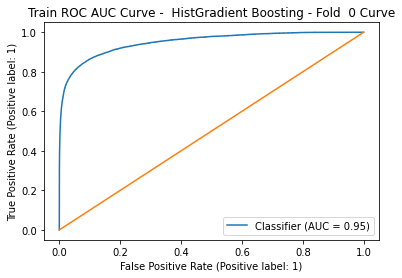

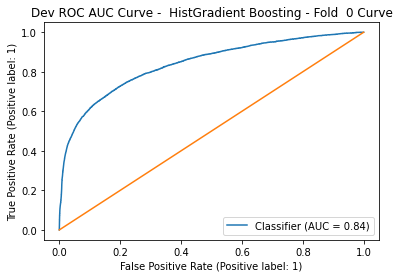

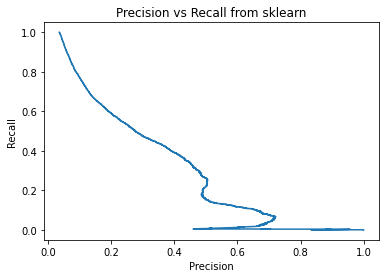

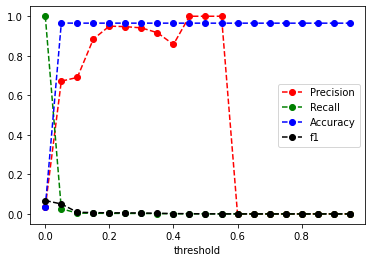

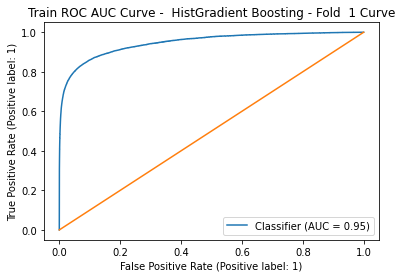

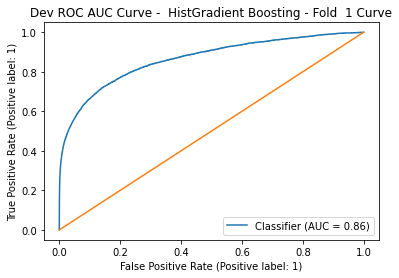

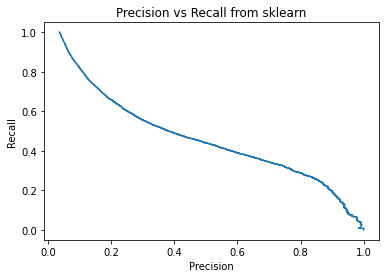

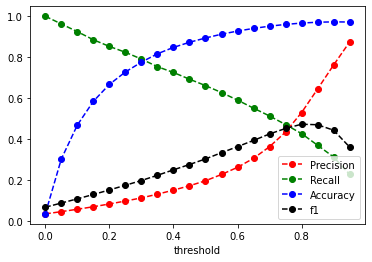

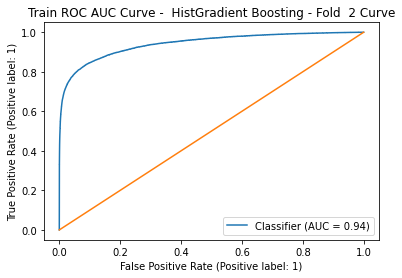

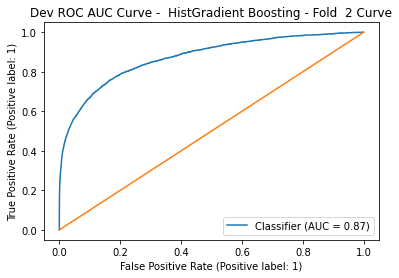

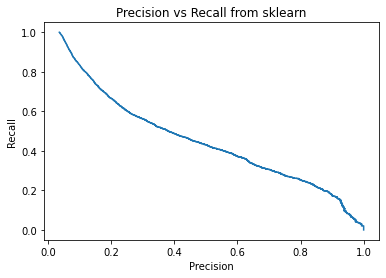

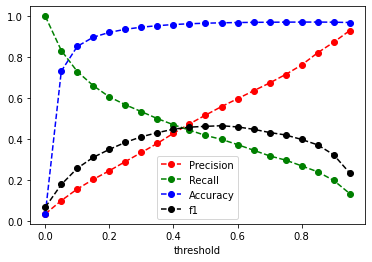

In [ ]:
# Generate the model metrics for each of the three folds
histGB_metrics_DF = []
for i_fold in range(0,numFolds): 
 histGB_metrics_DF.append(computeAndPlotMetrics(y_pred_train[i_fold],y_pred_train_prob[i_fold],
                              y_pred_dev[i_fold],y_pred_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'HistGradient Boosting - Fold  ' + str(i_fold) ))

#### Model 1 (HyperParameter Tuned)

In [ ]:
thresholds = np.arange(0, 1, .05)

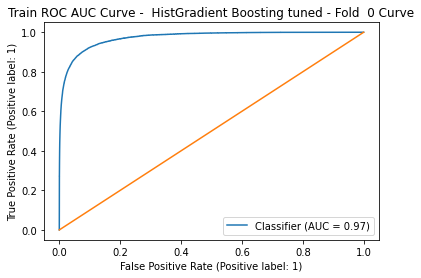

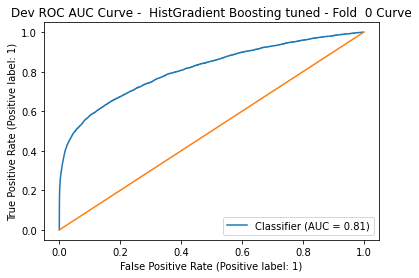

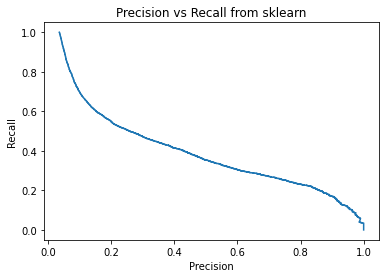

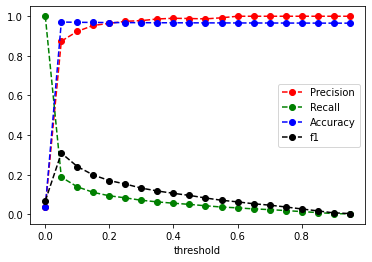

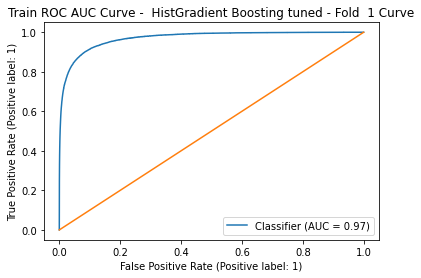

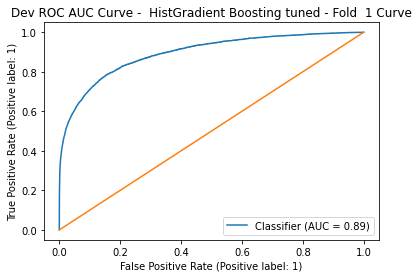

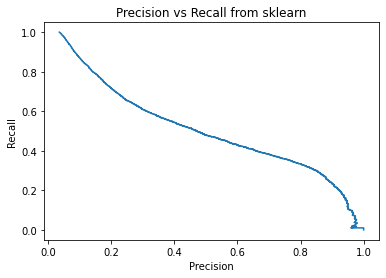

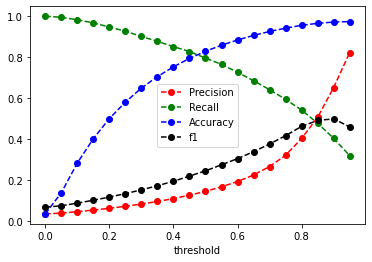

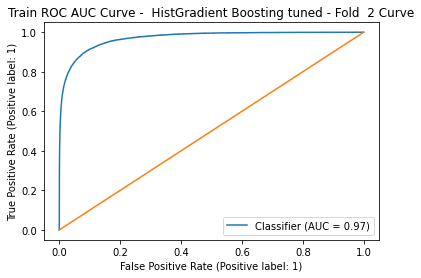

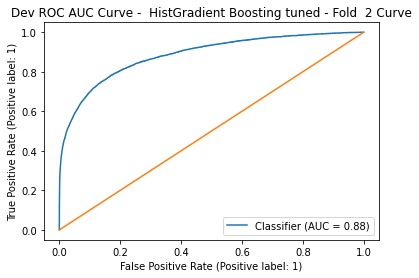

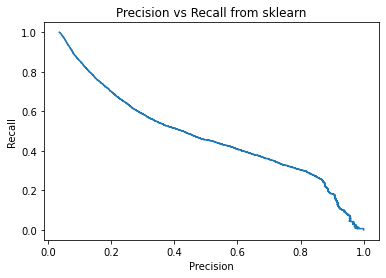

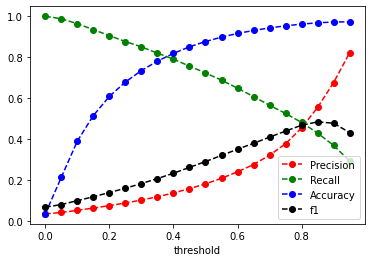

In [ ]:
# Generate the model metrics for each of the three folds

tunedhistGB_metrics_DF = []
for i_fold in range(0,numFolds): 
 tunedhistGB_metrics_DF.append(computeAndPlotMetrics(y_pred2_tunedHistGB_train[i_fold], y_pred2_tunedHistGB_train_prob[i_fold],
                              y_pred2_tunedHistGB_dev[i_fold],y_pred2_tunedHistGB_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'HistGradient Boosting tuned - Fold  ' + str(i_fold) ))

#### Model 2

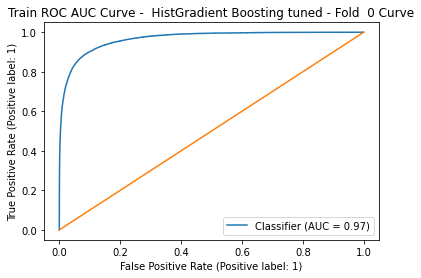

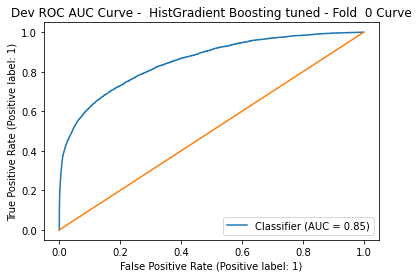

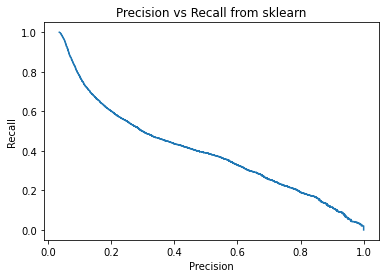

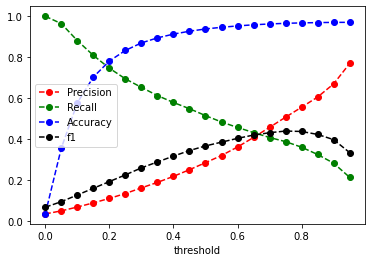

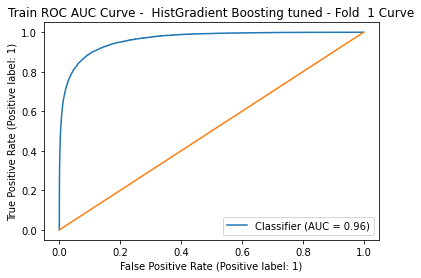

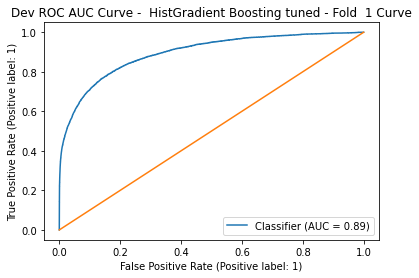

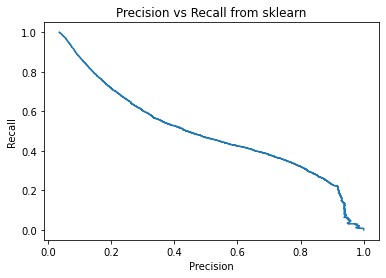

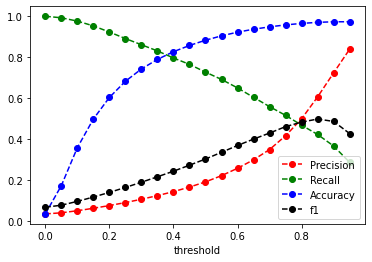

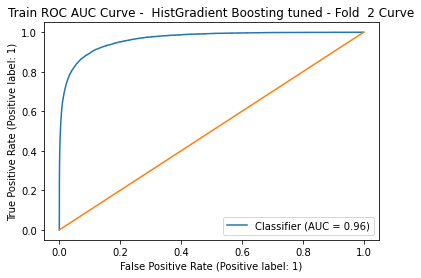

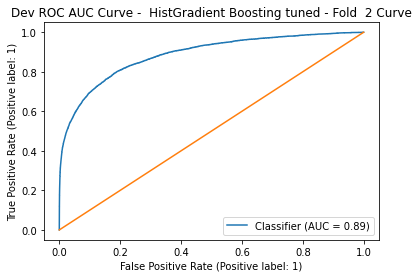

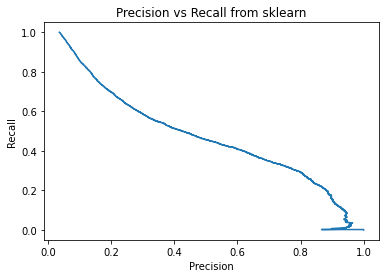

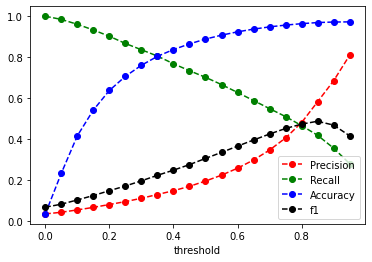

In [ ]:
# Generate the model metrics for each of the three folds

tunedhistGB2_metrics_DF = []
for i_fold in range(0,numFolds): 
 tunedhistGB2_metrics_DF.append(computeAndPlotMetrics(y_pred2_tunedHistGB_train[i_fold], y_pred2_tunedHistGB_train_prob[i_fold],
                              y_pred2_tunedHistGB_dev[i_fold],y_pred2_tunedHistGB_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'HistGradient Boosting tuned - Fold  ' + str(i_fold) ))

#### Model 3

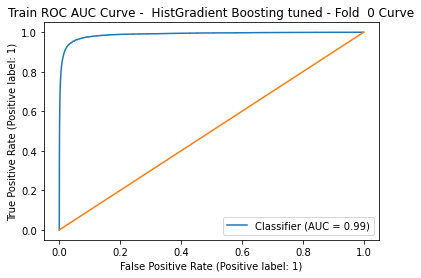

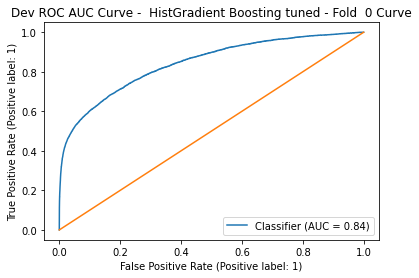

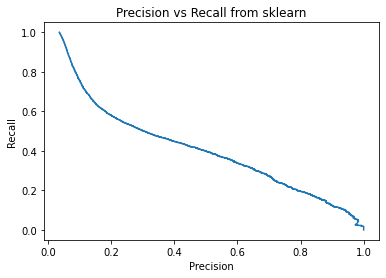

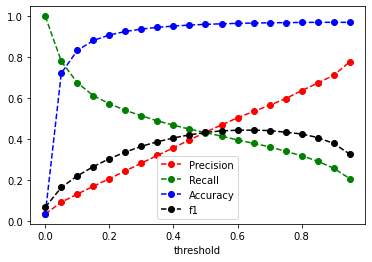

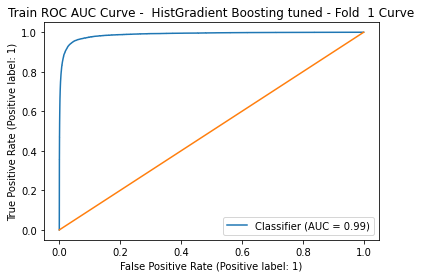

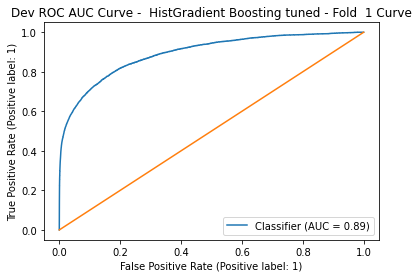

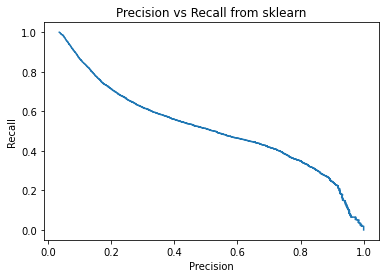

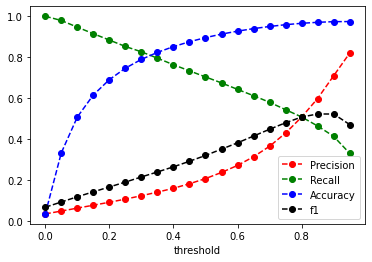

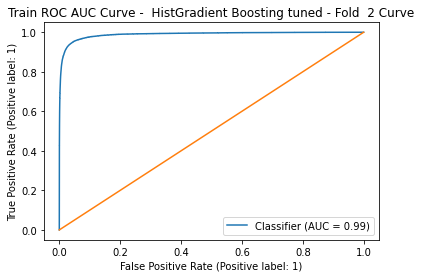

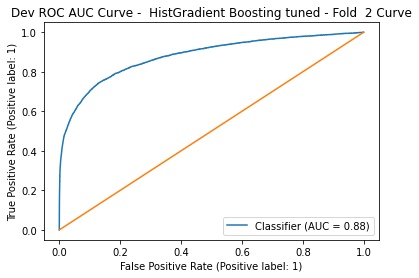

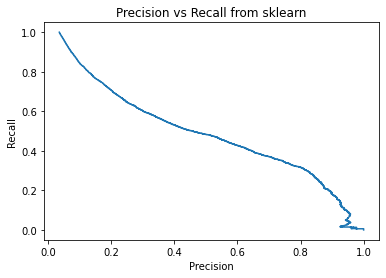

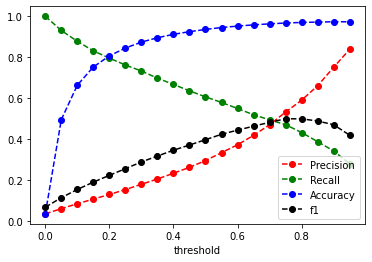

In [ ]:
# Generate the model metrics for each of the three folds

tunedhistGB3_metrics_DF = []
for i_fold in range(0,numFolds): 
 tunedhistGB3_metrics_DF.append(computeAndPlotMetrics(y_pred3_tunedHistGB_train[i_fold], y_pred3_tunedHistGB_train_prob[i_fold],
                              y_pred3_tunedHistGB_dev[i_fold],y_pred3_tunedHistGB_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'HistGradient Boosting tuned - Fold  ' + str(i_fold) ))

#### Model 4

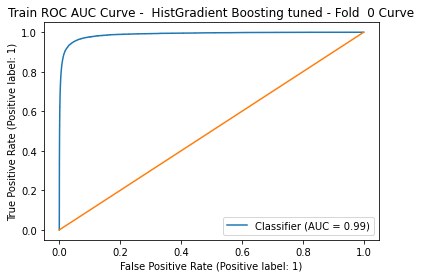

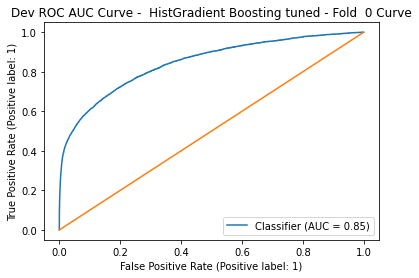

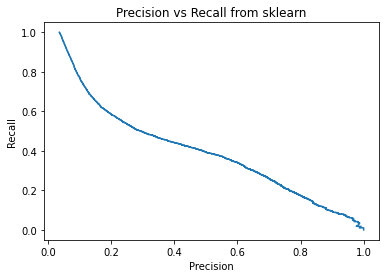

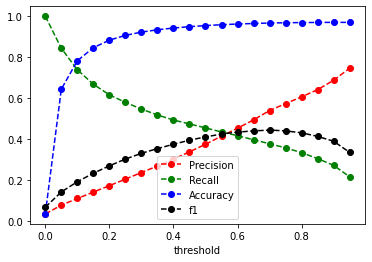

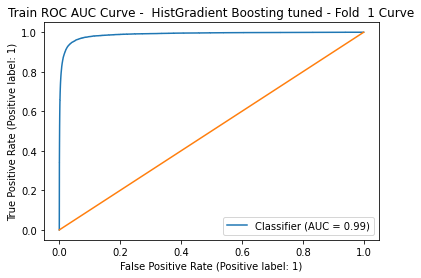

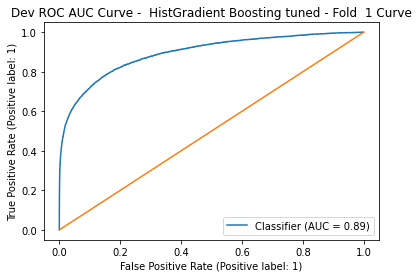

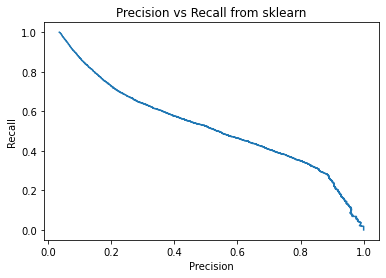

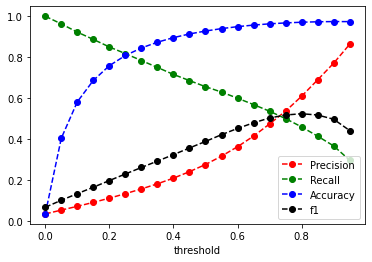

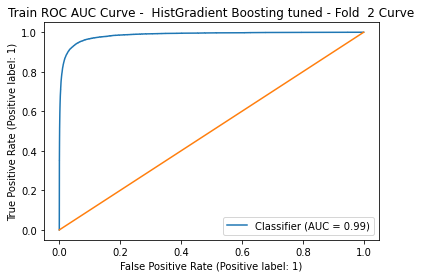

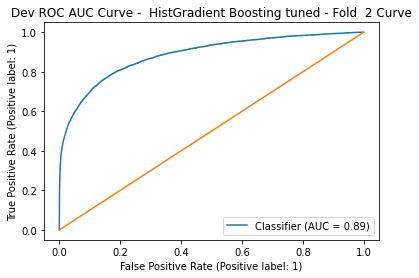

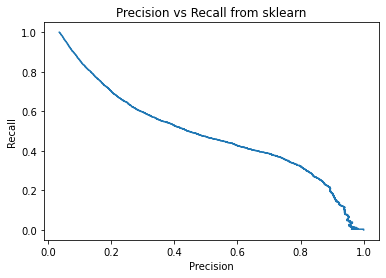

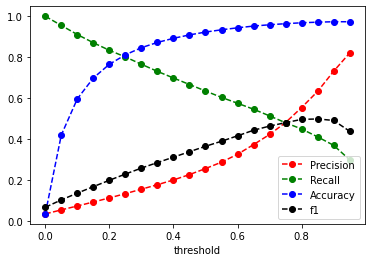

In [ ]:
# Generate the model metrics for each of the three folds

tunedhistGB4_metrics_DF = []
for i_fold in range(0,numFolds): 
 tunedhistGB4_metrics_DF.append(computeAndPlotMetrics(y_pred4_tunedHistGB_train[i_fold], y_pred4_tunedHistGB_train_prob[i_fold],
                              y_pred4_tunedHistGB_dev[i_fold],y_pred4_tunedHistGB_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'HistGradient Boosting tuned - Fold  ' + str(i_fold) ))

#### Model 5

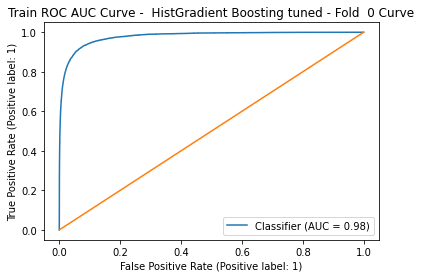

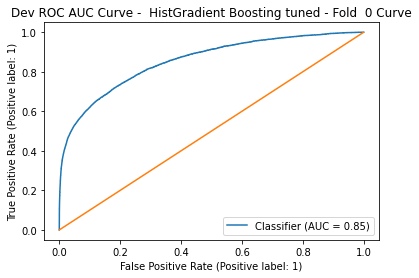

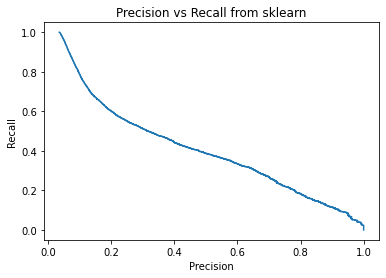

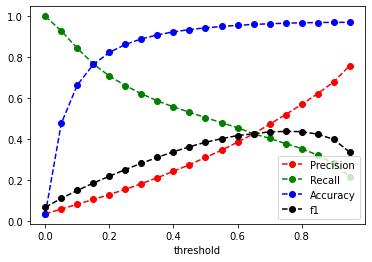

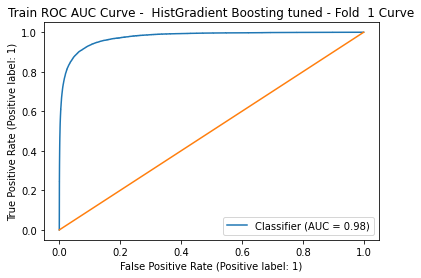

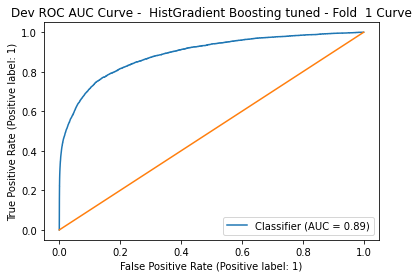

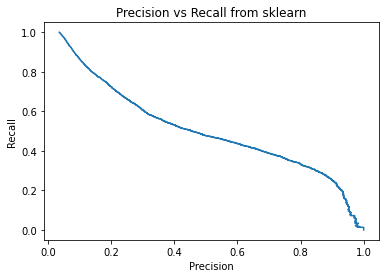

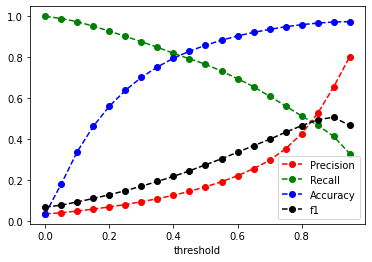

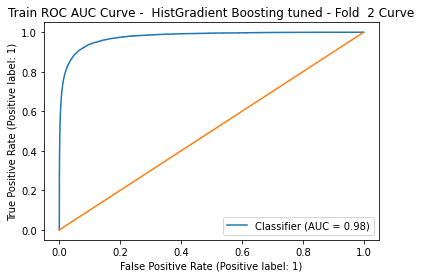

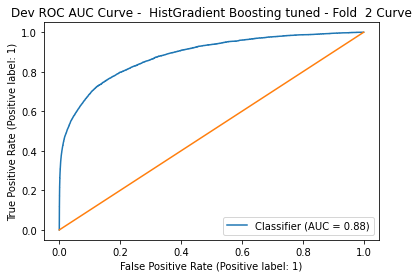

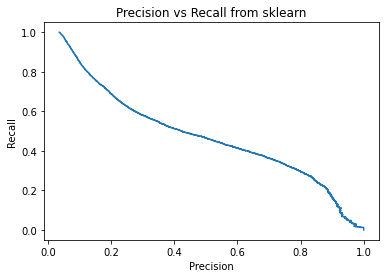

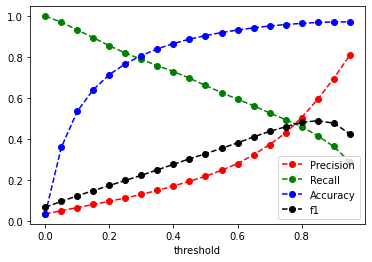

In [ ]:
# Generate the model metrics for each of the three folds

tunedhistGB5_metrics_DF = []
for i_fold in range(0,numFolds): 
 tunedhistGB5_metrics_DF.append(computeAndPlotMetrics(y_pred5_tunedHistGB_train[i_fold], y_pred5_tunedHistGB_train_prob[i_fold],
                              y_pred5_tunedHistGB_dev[i_fold],y_pred5_tunedHistGB_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'HistGradient Boosting tuned - Fold  ' + str(i_fold) ))

#### SMOTE sampled

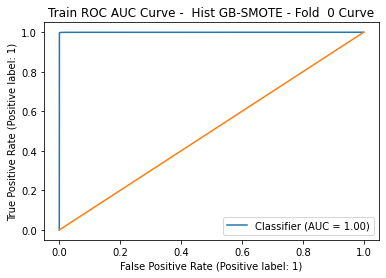

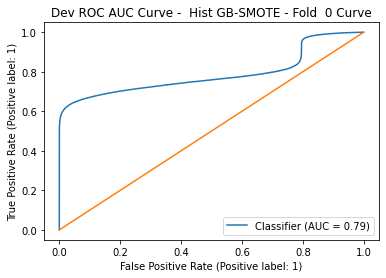

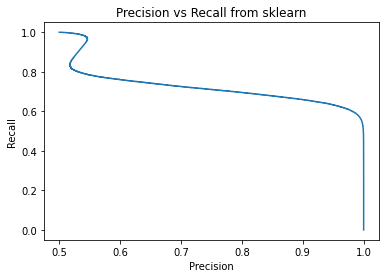

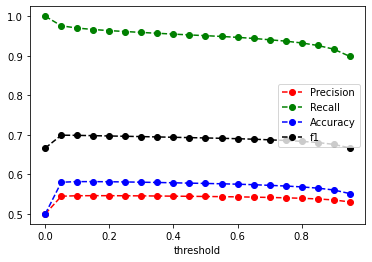

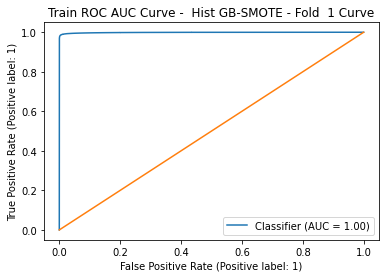

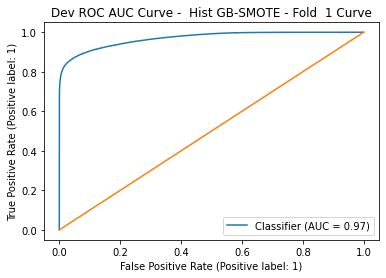

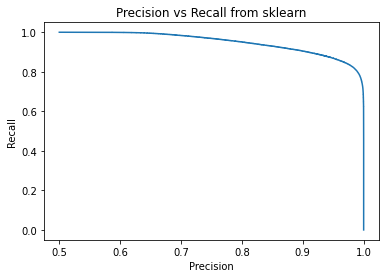

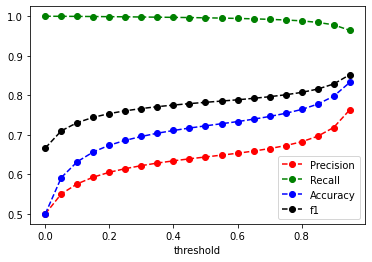

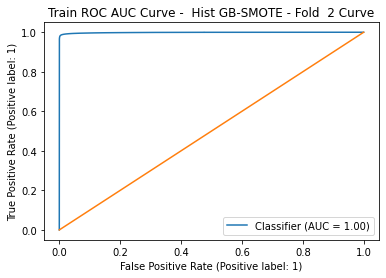

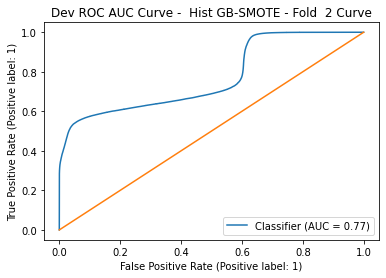

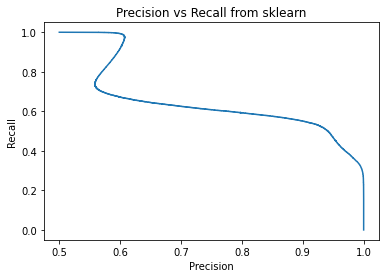

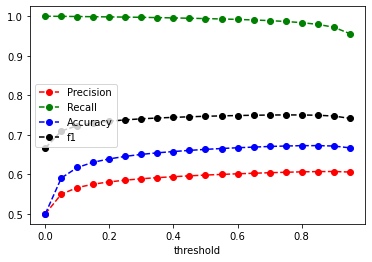

In [ ]:
# Generate the model metrics for each of the three folds

tunedhistGB6_smote_metrics_DF = []
for i_fold in range(0,numFolds): 
 tunedhistGB6_smote_metrics_DF.append(computeAndPlotMetrics(y_pred6_train[i_fold],y_pred6_train_prob[i_fold],
                              y_pred6_dev[i_fold],y_pred6_dev_prob[i_fold],
                                  y_dev_folds_smote[i_fold],y_train_folds_smote[i_fold],thresholds,
                                  'Hist GB-SMOTE - Fold  ' + str(i_fold) ))


#### 7. SMOTE Training sampled 

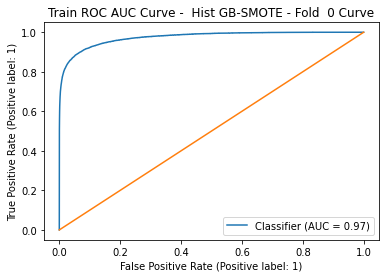

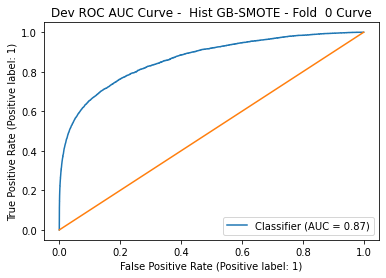

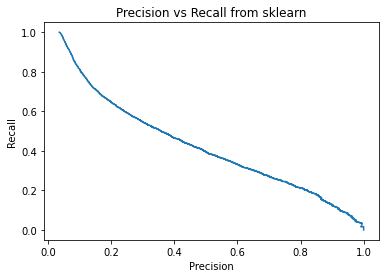

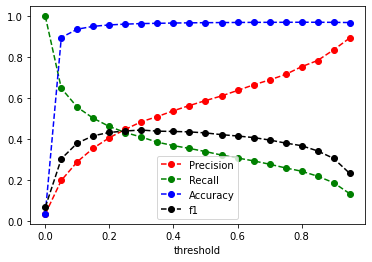

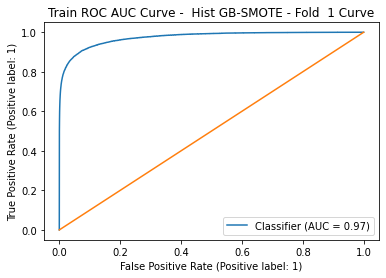

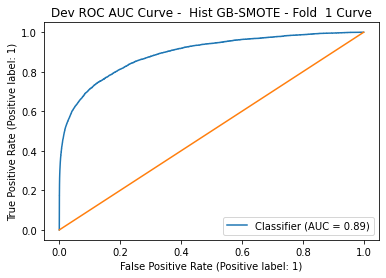

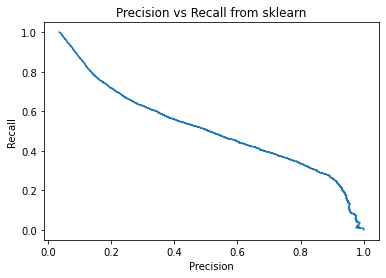

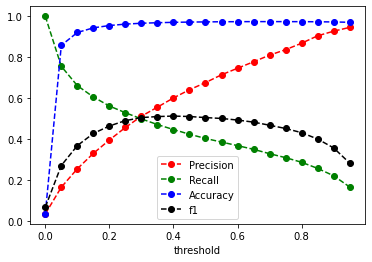

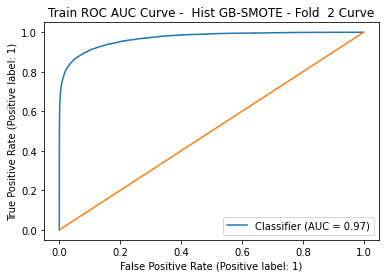

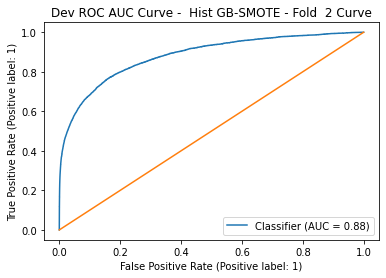

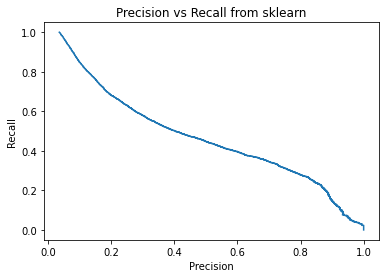

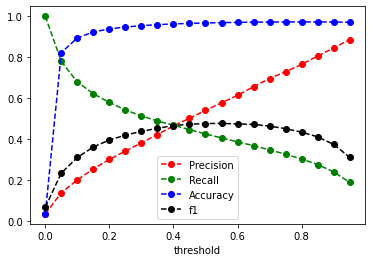

In [ ]:
# Generate the model metrics for each of the three folds

tunedhistGB7_smote_metrics_DF = []
for i_fold in range(0,numFolds): 
 tunedhistGB7_smote_metrics_DF.append(computeAndPlotMetrics(y_pred7_train[i_fold],y_pred7_train_prob[i_fold],
                              y_pred7_dev[i_fold],y_pred7_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'Hist GB-SMOTE - Fold  ' + str(i_fold) ))


# Summary

In [ ]:
histGB_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.979222  0.603182   0.909051  0.451325       0.950146
 1  development  0.965013  0.000290   1.000000  0.000145       0.839501,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.979116  0.598221   0.915084  0.444356       0.947020
 1  development  0.893725  0.303410   0.196854  0.661440       0.864133,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.979509  0.605969   0.926236  0.450276       0.941586
 1  development  0.965989  0.462551   0.517235  0.418324       0.872674]

In [ ]:
tunedhistGB_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.928322  0.465944   0.315124  0.893648       0.973032
 1  development  0.966492  0.082359   0.986667  0.042973       0.812590,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.924418  0.451300   0.302484  0.888348       0.970020
 1  development  0.828649  0.245279   0.144985  0.795732       0.893386,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.927522  0.460135   0.311173  0.882695       0.970590
 1  development  0.876431  0.290639   0.181841  0.723537       0.884552]

In [ ]:
tunedhistGB2_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.918723  0.431813   0.285818  0.882686       0.966573
 1  development  0.937850  0.367032   0.285129  0.514954       0.853597,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.913232  0.413723   0.270909  0.874991       0.963165
 1  development  0.882945  0.303025   0.191388  0.727207       0.894629,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.918460  0.428404   0.283820  0.873258       0.964398
 1  development  0.888527  0.305843   0.195519  0.701902       0.885665]

In [ ]:
tunedhistGB3_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.963974  0.646829   0.492268  0.942868       0.988678
 1  development  0.960385  0.432790   0.433673  0.431911       0.842383,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.961442  0.631213   0.474349  0.943085       0.988297
 1  development  0.895543  0.320444   0.207445  0.703833       0.893609,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.965156  0.653236   0.501125  0.937936       0.988793
 1  development  0.935604  0.397242   0.295340  0.606505       0.879715]

In [ ]:
tunedhistGB4_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.962336  0.635962   0.480469  0.940254       0.988700
 1  development  0.954381  0.410993   0.374850  0.454849       0.845213,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.961902  0.634162   0.477520  0.943739       0.988649
 1  development  0.927792  0.388698   0.276155  0.656069       0.894264,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.955171  0.591222   0.434130  0.926466       0.985463
 1  development  0.922742  0.365169   0.256254  0.635110       0.885517]

In [ ]:
tunedhistGB5_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.938112  0.507071   0.351489  0.909764       0.978178
 1  development  0.943499  0.384845   0.310847  0.505081       0.854953,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.934629  0.490880   0.337376  0.900690       0.975625
 1  development  0.858382  0.274547   0.167253  0.765825       0.890419,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.936928  0.500854   0.346335  0.904326       0.976680
 1  development  0.905357  0.328697   0.218596  0.662262       0.883836]

In [ ]:
tunedhistGB6_smote_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.997894  0.997891   0.999301  0.996486       0.999961
 1  development  0.577088  0.692149   0.544113  0.950842       0.788270,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.990126  0.990053   0.997327  0.982886       0.998865
 1  development  0.722738  0.782250   0.644016  0.996047       0.969227,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.989633  0.989554   0.997191  0.982033       0.998707
 1  development  0.663243  0.746953   0.598244  0.994051       0.772046]

In [ ]:
tunedhistGB7_smote_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.985997  0.769610   0.906835  0.668457       0.974142
 1  development  0.968569  0.430452   0.588176  0.339431       0.865414,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.985791  0.761775   0.921397  0.649292       0.973823
 1  development  0.972359  0.505229   0.676077  0.403310       0.893489,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.985870  0.767947   0.902716  0.668191       0.969662
 1  development  0.967254  0.476190   0.540690  0.425439       0.881433]

In this notebook, we utilized the HistGradient Boosting technique to enhance ROC-AUC scores compared to simpler classification models like Logistic Regression and Decision Trees.

We began with the default method and then proceeded with hyperparameter tuning to refine the results. Among the various models tested, Model 5 emerged as the most promising, exhibiting a comparable AUC score to other high-performing models while achieving a significantly higher recall score. Model 4 also demonstrated comparable performance, with a similar ROC-AUC score to Model 5 but with higher accuracy and precision scores.

However, it's important to note that the SMOTE sampled model, which achieved the highest ROC-AUC score, is likely overfitting. The synthetic data points generated by SMOTE are present in both the training and development sets, potentially leading the model to overlearn these samples and inflate its score.

This overfitting issue is underscored by the next model, SMOTE Training sampled model, where SMOTE sampling is applied only to the training set. Despite this, the ROC-AUC score remains comparable to other models, suggesting a more reliable performance.

Therefore, we recommend choosing either Model 4 or Model 5 for further analysis, considering their robust performance metrics and potential avoidance of overfitting issues.